# ARIMA Time Series Forecasting

ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time

ARIMA models combine three distinct components:
1. Autoregression, represented as AR
2. Differencing, represented as I
3. Moving average, represented as MA

Three components/parameters: AR + I + MA (p, d, q)

In [493]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 1: Load and Preprocess the Dataset

In [494]:
Canadian_data=pd.read_csv('Canadian Car Sales.csv')

Canadian_data.reset_index(inplace=True)
Canadian_data = Canadian_data[['REF_DATE', 'VALUE']]

Canadian_data['REF_DATE'] = pd.to_datetime(Canadian_data['REF_DATE'])

print(Canadian_data.dtypes)
Canadian_data.head()

REF_DATE    datetime64[ns]
VALUE              float64
dtype: object


,REF_DATE,VALUE
0,1953-01-01,21742.0
1,1953-02-01,28711.0
2,1953-03-01,36867.0
3,1953-04-01,39903.0
4,1953-05-01,37717.0


In [495]:
# display last 12 rows
Canadian_data.tail(12)

,REF_DATE,VALUE
6570,2023-03-01,5813312.0
6571,2023-04-01,5666677.0
6572,2023-05-01,6718800.0
6573,2023-06-01,6069241.0
6574,2023-07-01,5507734.0
6575,2023-08-01,6101383.0
6576,2023-09-01,6078980.0
6577,2023-10-01,5790248.0
6578,2023-11-01,5590523.0
6579,2023-12-01,5127895.0


In [496]:
# Check for missing values
print(Canadian_data.isnull().sum())

REF_DATE    0
VALUE       0
dtype: int64


In [497]:
# # Adjust figure size
# plt.figure(figsize=(20, 10))

# # Plot the lineplot
# sns.lineplot(data=Canadian_data, x='REF_DATE', y='VALUE')
# plt.xlabel('Year')
# plt.ylabel('Sales')
# plt.title('Monthly Sales of New Motor Vehicles in Canada')
# plt.show()

## Step 2: Check for Stationarity

In [498]:
# Function to perform the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Applying the Dickey-Fuller test on the 'VALUE' column
test_stationarity(Canadian_data['VALUE'])

Results of Dickey-Fuller Test:


Test Statistic                    7.998040
p-value                           1.000000
#Lags Used                       35.000000
Number of Observations Used    6546.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861982
Critical Value (10%)             -2.567005
dtype: float64


If the p-value is less than 0.05 and the test statistic is less than the critical values, we can conclude the series is stationary.

But it is not, we'll consider applying transformations to make it stationary.

## Step 3: Data Transformation

In [499]:
# First differencing
# Canadian_data['VALUE_diff'] = Canadian_data['VALUE'].diff()

Canadian_data['Sales_First_Difference'] = Canadian_data['VALUE'] - Canadian_data['VALUE'].shift(1)
Canadian_data['Seasonal_First_Difference']=Canadian_data['VALUE']-Canadian_data['VALUE'].shift(12)
Canadian_data.dropna().head()

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference
12,1954-01-01,17669.0,-950.0,-4073.0
13,1954-02-01,22451.0,4782.0,-6260.0
14,1954-03-01,34097.0,11646.0,-2770.0
15,1954-04-01,36801.0,2704.0,-3102.0
16,1954-05-01,33477.0,-3324.0,-4240.0


In [500]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")


# Again testing if data is stationary
adfuller_test(Canadian_data['Seasonal_First_Difference'].dropna())

ADF Test Statistic : -12.387575199278704
p-value : 4.8703080717044984e-23
#Lags Used : 35
Number of Observations : 6534
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Axes: >

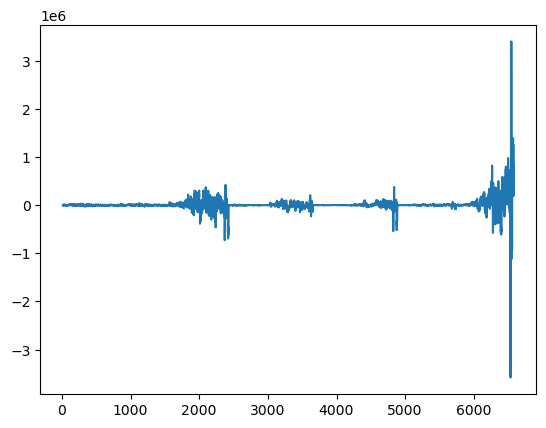

In [501]:
Canadian_data['Seasonal_First_Difference'].plot()

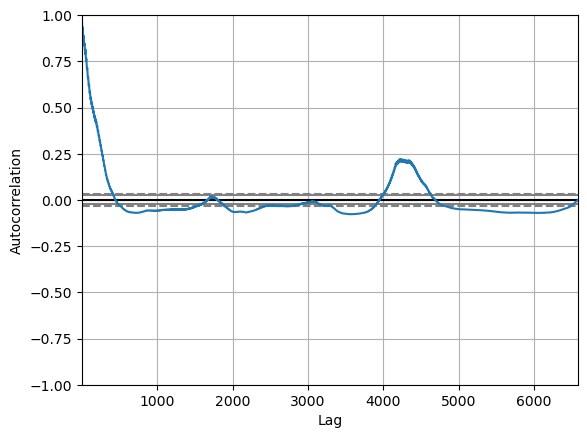

In [502]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Canadian_data['VALUE'])
plt.show()

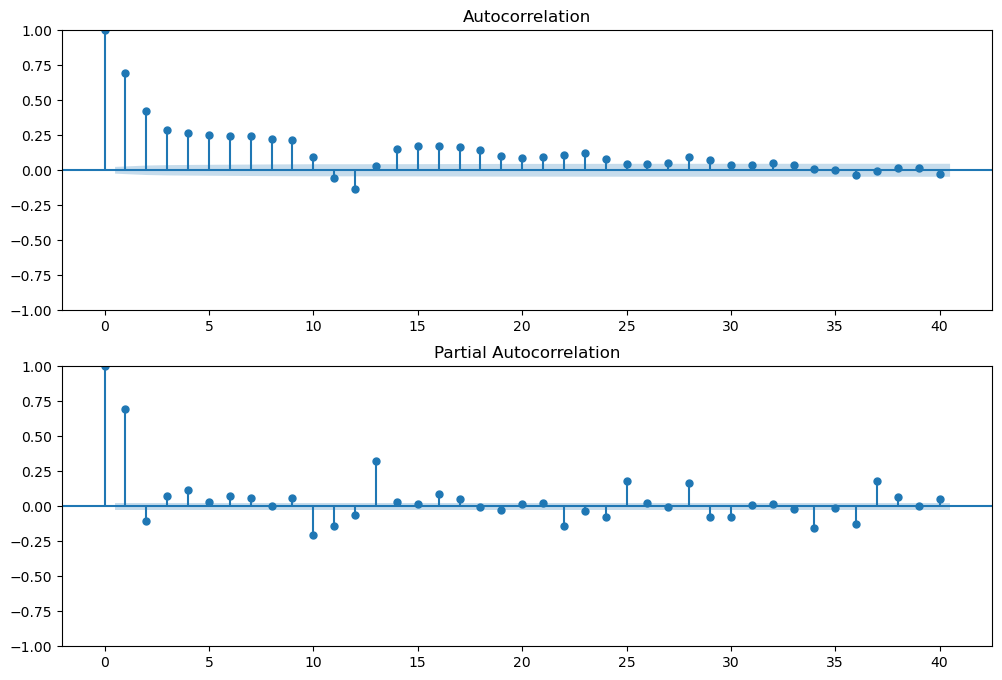

In [503]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Canadian_data['Seasonal_First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Canadian_data['Seasonal_First_Difference'].dropna(),lags=40,ax=ax2)

In [504]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(Canadian_data['VALUE'], order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                 6582
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -86145.274
Date:                Sat, 20 Apr 2024   AIC                         172296.547
Time:                        11:40:19   BIC                         172316.923
Sample:                             0   HQIC                        172303.590
                               - 6582                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6148      0.013    -48.093      0.000      -0.640      -0.590
ma.L1          0.7225      0.012     62.276      0.000       0.700       0.745
sigma2      1.396e+10   1.91e-12    7.3e+21      0.000     1.4e+10     1.4e+10
===================================================================================
Ljung-Box (L1) (Q):                  22.11   Jarque-Bera (JB):           1190318.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.28   Skew:                             3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.91e+35. Standard errors may be unstable.
"""

<Axes: >

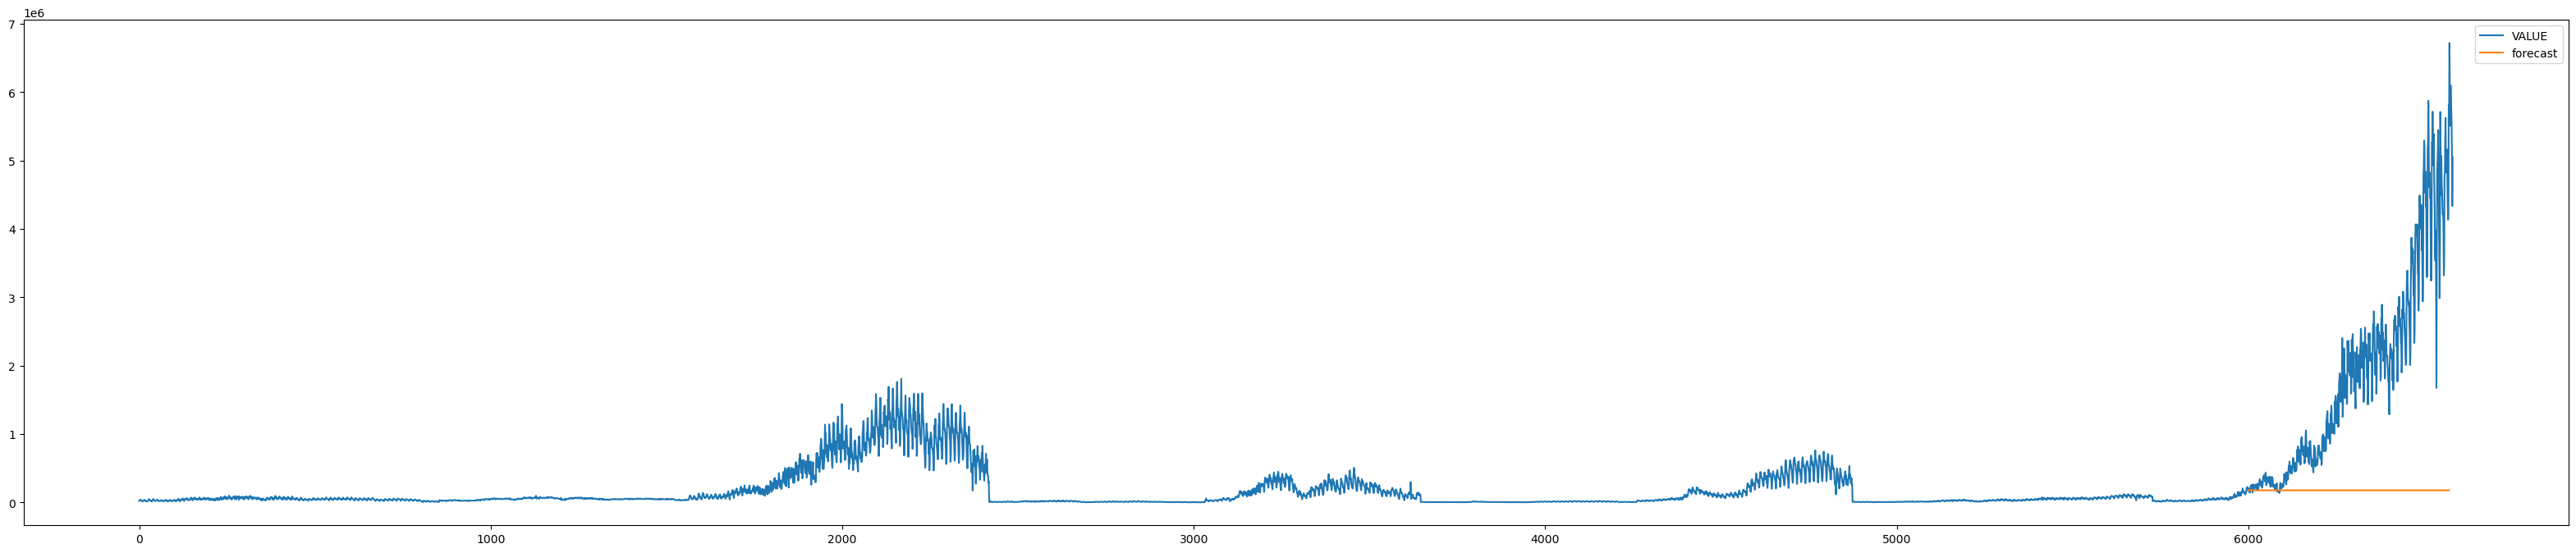

In [505]:
Canadian_data['forecast']=model_fit.predict(start=6000,end=6571,dynamic=True)
Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27588D+01    |proj g|=  9.46527D-02

At iterate    5    f=  1.27058D+01    |proj g|=  5.20435D-02

At iterate   10    f=  1.26776D+01    |proj g|=  1.51578D-02

At iterate   15    f=  1.26767D+01    |proj g|=  2.01380D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.102D-05   1.268D+01
  F =   12.676744798160293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<Axes: >

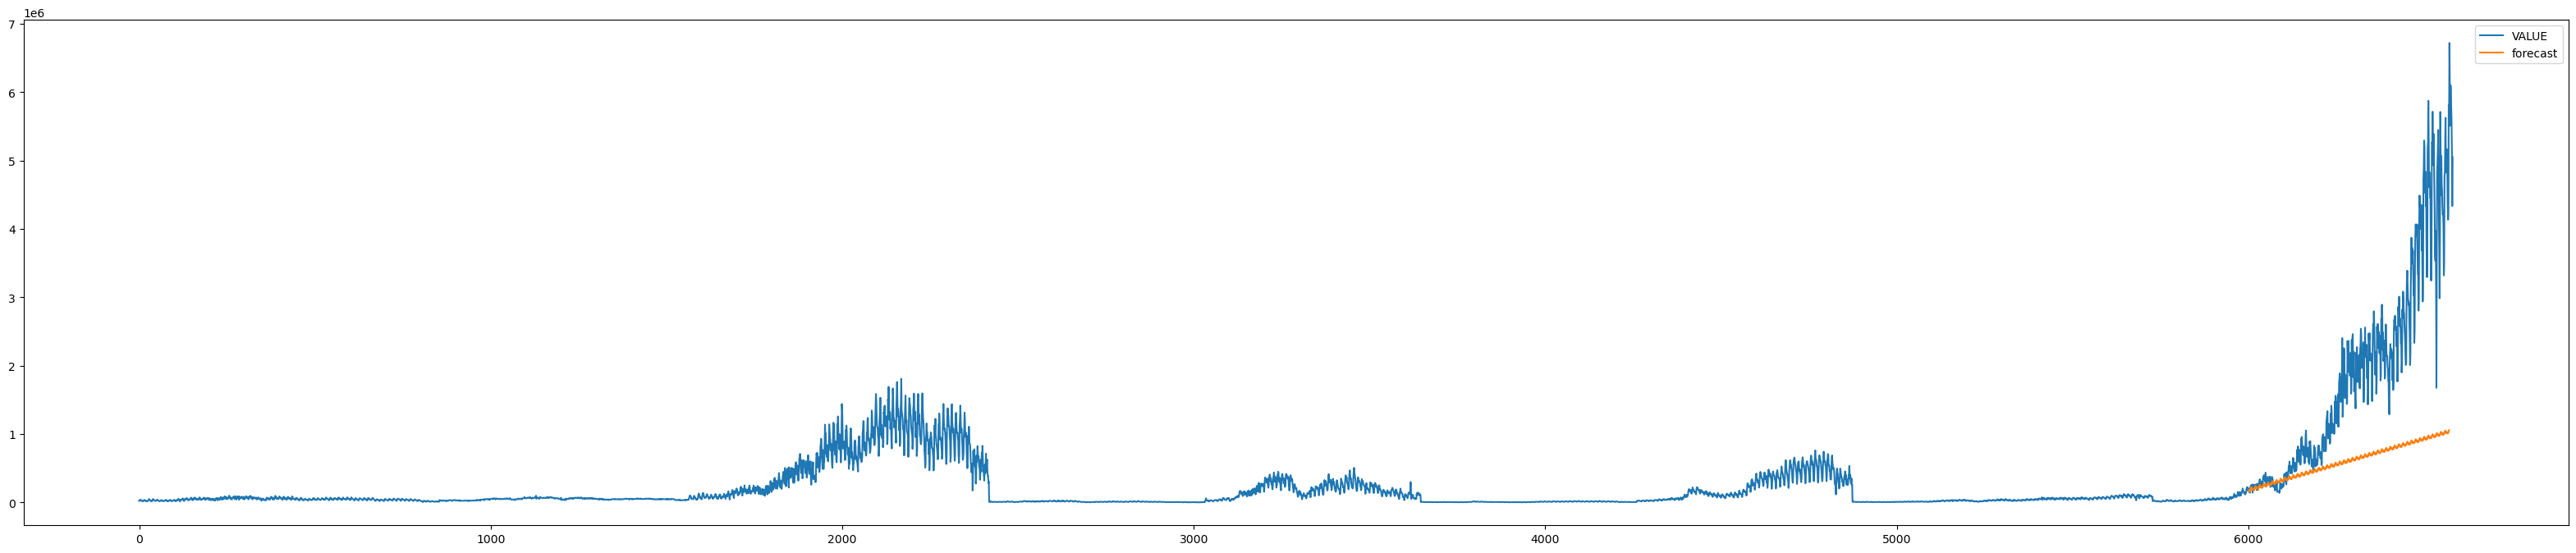

In [506]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
Canadian_data['forecast']=results.predict(start=6000,end=6571,dynamic=True)
Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

<Axes: >

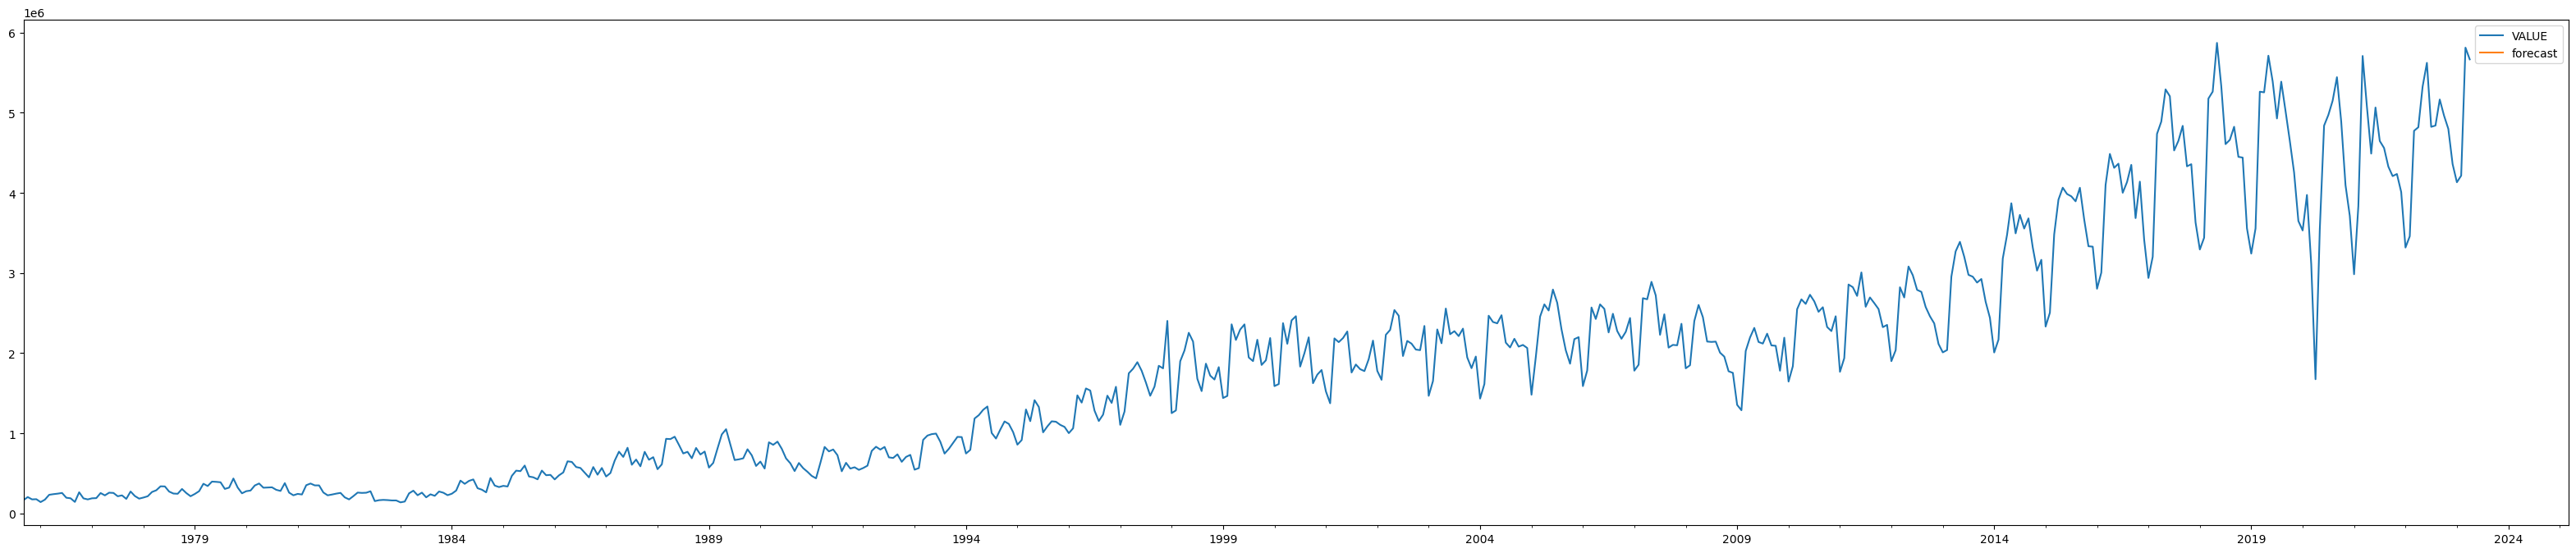

In [524]:
# # Convert the index to a datetime index if it is not already one
# # This assumes the index represents dates in a format that pandas can recognize
# Canadian_data['REF_DATE'] = pd.to_datetime(Canadian_data['REF_DATE'])
# Canadian_data.set_index('REF_DATE', inplace=True)

from pandas.tseries.offsets import DateOffset

# Now you should be able to add DateOffset to the last date in the index
future_dates = [Canadian_data.index[-1] + DateOffset(months=x) for x in range(0, 24)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=Canadian_data.columns)

# Concatenate the original dataframe with the future dates dataframe
future_df = pd.concat([Canadian_data, future_datest_df])

# Assuming 'results' is your fitted model and it's already defined
future_df['forecast'] = results.predict(start=len(Canadian_data), end=len(Canadian_data)+24, dynamic=True)
future_df[['VALUE', 'forecast']].plot(figsize=(40, 8))


In [508]:
# # Plot to see the effect of differencing
# plt.figure(figsize=(10, 6))
# plt.plot(Canadian_data['Seasonal_First_Difference'])
# plt.title('Seasonal Difference of Monthly Sales of New Motor Vehicles in Canada')
# plt.xlabel('Date')
# plt.ylabel('Seasonal Difference of Sales')
# plt.show()

# # Re-run the ADF test
# test_stationarity(Canadian_data['Seasonal_First_Difference'].dropna())

In [509]:
# # Log transformation
# Canadian_data['VALUE_log'] = np.log(Canadian_data['VALUE'])

# # Plot to see the effect of logarithmic transformation
# plt.figure(figsize=(10, 6))
# plt.plot(Canadian_data['VALUE_log'])
# plt.title('Log Transformed Monthly Sales of New Motor Vehicles in Canada')
# plt.xlabel('Date')
# plt.ylabel('Log of Sales')
# plt.show()

# # Re-run the ADF test
# test_stationarity(Canadian_data['VALUE_log'].dropna())

In [510]:
# from scipy.stats import boxcox

# # Box-Cox transformation
# Canadian_data['VALUE_boxcox'], lam = boxcox(Canadian_data['VALUE'])

# # Store lambda for later inverse transformation if needed
# print("Lambda for Box-Cox Transformation:", lam)

# # Plot to see the effect of Box-Cox transformation
# plt.figure(figsize=(10, 6))
# plt.plot(Canadian_data.index, Canadian_data['VALUE_boxcox'])
# plt.title('Box-Cox Transformed Monthly Sales of New Motor Vehicles in Canada')
# plt.xlabel('Date')
# plt.ylabel('Box-Cox Transformed Sales')
# plt.show()

# # Re-run the ADF test
# test_stationarity(Canadian_data['VALUE_boxcox'].dropna())


First Difference of Sales has the lowest p-value, hence use VALUE_boxcox for future steps

In [511]:
#check for duplicates
print(Canadian_data.duplicated().sum())

# Drop NA values that are generated by differencing
Canadian_data = Canadian_data.dropna()

0


## Step 4: Identify and Remove Outliers

In [512]:
# # Calculate IQR
# Q1 = Canadian_data['VALUE'].quantile(0.25)
# Q3 = Canadian_data['VALUE'].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter outliers
# filtered_data = Canadian_data[(Canadian_data['VALUE'] >= lower_bound) & (Canadian_data['VALUE'] <= upper_bound)]

# # Plot to see data after removing outliers
# plt.figure(figsize=(10, 6))
# plt.plot(filtered_data['VALUE'])
# plt.title('Seasonal Difference of Monthly Sales of New Motor Vehicles in Canada After Removing Outliers')
# plt.xlabel('Date')
# plt.ylabel('Seasonal Difference of Sales')
# plt.show()


## Step 5: Split the Data into Training and Test Sets

In [513]:
# # Calculate the split point
# split_point = int(len(filtered_data) * 0.8)

# # Split into training and test sets
# train_data = filtered_data[:split_point]
# test_data = filtered_data[split_point:]

# # Plot both to visually inspect the split
# plt.figure(figsize=(10, 6))
# plt.plot(train_data['VALUE'], label='Train Data')
# plt.plot(test_data['VALUE'], label='Test Data', color='orange')
# plt.title('Train-Test Split of Data')
# plt.xlabel('Date')
# plt.ylabel('Seasonal Difference of Sales')
# plt.legend()
# plt.show()

## Step 6: Model Identification

In [514]:
# # Plot ACF and PACF for the differenced data
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plot_acf(train_data['Seasonal_First_Difference'], ax=plt.gca(), lags=20)
# plt.title('Autocorrelation Function')

# plt.subplot(122)
# plot_pacf(train_data['Seasonal_First_Difference'], ax=plt.gca(), lags=20)
# plt.title('Partial Autocorrelation Function')
# plt.tight_layout()
# plt.show()

## Step 7: Model Fitting

In [515]:
# # Assuming p=1, d=1, q=1 from the previous identification step
# model = ARIMA(train_data['VALUE'], order=(1, 1, 1))
# model_fit = model.fit()

# # Summary of the model
# print(model_fit.summary())

# # Check residuals
# residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# residuals.plot(title="Residuals", ax=plt.gca())
# plt.subplot(122)
# residuals.plot(kind='kde', title='Density', ax=plt.gca())
# plt.show()

### ARIMA Model Evaluation Summary

#### Model Fit Statistics
- **Log Likelihood**: 5790.216
  - High log likelihood indicates a good fit to the data.
- **AIC (Akaike Information Criterion)**: -11574.432
  - Lower AIC values suggest a better model, with a negative value indicating a very strong model.
- **BIC (Bayesian Information Criterion)**: -11554.727
  - Lower BIC values also suggest a better model, with more strict penalties for models with more parameters.

#### Parameter Estimates
- **ar.L1 (AR1 coefficient)**: 0.7453 (p-value near 0)
  - Significant positive autocorrelation at lag 1.
- **ma.L1 (MA1 coefficient)**: -0.8836 (p-value near 0)
  - Significant negative coefficient, indicating a significant moving average component.

#### Model Diagnostics
- **sigma2**: 0.0065
  - Low estimated variance of residuals suggests a good model fit.
- **Ljung-Box Test**: Statistic = 69.16, p-value ≈ 0
  - Indication of remaining autocorrelation in residuals at lag 1, suggesting potential model improvement.
- **Jarque-Bera Test**: Statistic = 475193.70, p-value = 0
  - The residuals are not normally distributed, indicating issues such as heavy tails or skewness.
- **Heteroskedasticity Test**: Statistic = 1.78, p-value = 0
  - Significant heteroskedasticity detected, implying varying error variance.

#### Skewness and Kurtosis
- **Skew**: -2.26
  - Left-skewed distribution of residuals.
- **Kurtosis**: 49.33
  - Indicates leptokurtosis, suggesting heavy tails compared to a normal distribution.


## Step 8: Model Evaluation and Forecasting

In [516]:
# # Make forecast
# forecast = model_fit.forecast(steps=len(test_data))

# # Visual comparison
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data['VALUE'], label='Train Data')
# plt.plot(test_data.index, test_data['VALUE'], label='Actual Test Data')
# plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
# plt.title('ARIMA Forecast vs Actual')
# plt.legend()
# plt.show()

# # Calculate performance metrics
# mse = mean_squared_error(test_data['VALUE'], forecast)
# mae = mean_absolute_error(test_data['VALUE'], forecast)
# rmse = np.sqrt(mse)
# print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

### Forecast Accuracy Metrics

- **Mean Squared Error (MSE)**: 0.7418876672585624
  - MSE is the average of the squared differences between the predicted and actual values. It places greater weight on larger errors, making it sensitive to outliers.
  - A lower MSE value is generally better, and a value of 0.7419 suggests moderate error in the predictions. MSE is particularly useful because it punishes larger errors more harshly, highlighting significant deviations in predictions.

- **Mean Absolute Error (MAE)**: 0.6798012966121902
  - MAE is the average absolute difference between the predicted and actual values, providing a straightforward measure of the average error magnitude.
  - An MAE of 0.6798 suggests that the model's predictions are, on average, approximately 0.680 units away from the actual values. The MAE is less sensitive to outliers compared to MSE and provides a more straightforward interpretation of overall prediction accuracy.

- **Root Mean Squared Error (RMSE)**: 0.8613290122006586
  - RMSE is the square root of the MSE and is in the same units as the data. Like MSE, RMSE is sensitive to large errors and provides a measure of the typical error magnitude.
  - An RMSE of 0.8613 indicates that the standard deviation of the prediction errors is about 0.861 units. Like MSE, RMSE gives a relatively high weight to large errors, which means if there are large errors, RMSE would be higher.


## Step 9: Output the Forecasted Data

In [517]:

# # Generate sample data (as we simulated here; replace this with your actual data loading step)
# Canadian_data = pd.DataFrame({
#     'REF_DATE': pd.date_range(start='2024-01-01', periods=12, freq='M'),
#     'VALUE': np.random.poisson(lam=200, size=12)
# })

# # Apply Box-Cox transformation
# Canadian_data['VALUE_boxcox'], _ = boxcox(Canadian_data['VALUE'])

# # Split into training and test data (80% train, 20% test)
# split_point = int(len(Canadian_data) * 0.8)
# train_data = Canadian_data[:split_point]
# test_data = Canadian_data[split_point:]

# # Fit ARIMA model with parameters (1, 1, 1)
# model = ARIMA(train_data['VALUE_boxcox'], order=(1, 1, 1))
# model_fit = model.fit()

# # Forecast for the next 12 months
# additional_forecast = model_fit.forecast(steps=12)

# # Create index for plotting the forecast
# last_date = test_data['REF_DATE'].iloc[-1]
# future_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:]  # Start from month after last date

# # Combine historical and forecast data for plotting
# historical_dates = pd.date_range(start=train_data['REF_DATE'].iloc[0], periods=len(train_data) + len(test_data), freq='M')
# forecast_dates = historical_dates.append(future_dates)
# forecast_values = pd.concat([pd.Series(model_fit.predict(start=1, end=len(forecast_dates)-12)), pd.Series(additional_forecast, index=future_dates)])

# # Plotting the results
# plt.figure(figsize=(14, 7))
# plt.plot(historical_dates, pd.concat([train_data['VALUE_boxcox'], test_data['VALUE_boxcox']]), label='Historical Data')
# plt.plot(forecast_dates, forecast_values, label='Forecasted Data', color='red')
# plt.title('Extended ARIMA Forecast for the Next 12 Months')
# plt.xlabel('Date')
# plt.ylabel('Box-Cox Transformed Sales')
# plt.legend()
# plt.grid(True)
# plt.show()

In [518]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from scipy.stats import boxcox
# from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# # Load your data here
# # For this example, I will simulate loading data
# Canadian_data = pd.DataFrame({
#     'REF_DATE': pd.date_range(start='2000-01-01', periods=288, freq='M'),
#     'VALUE': np.random.poisson(lam=200, size=288)
# })

# # Transformation (Apply Box-Cox transformation)
# Canadian_data['VALUE'], _ = boxcox(Canadian_data['VALUE'])

# # Split into training data (assuming you're using previously fitted model so no test data split)
# train_data = Canadian_data

# # Assuming the ARIMA model is already fitted and saved as 'arima_model.pkl'
# # Here's how you might load it:
# # model_fit = SARIMAXResults.load('path/to/arima_model.pkl')

# # For the purpose of this example, since we cannot save/load, I'm fitting the model here
# # Normally, you'd skip this step because you're loading a pre-trained model
# model = ARIMA(train_data['VALUE'], order=(1, 1, 1))
# model_fit = model.fit()

# # Forecast for the next 12 months
# additional_forecast = model_fit.forecast(steps=120)

# # Create index for plotting the forecast
# last_date = train_data['REF_DATE'].iloc[-1]
# future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=120, freq='M')

# # Plotting the results
# plt.figure(figsize=(14, 7))
# plt.plot(train_data['REF_DATE'], train_data['VALUE'], label='Historical Data')
# plt.plot(future_dates, additional_forecast, label='Forecasted Data', color='red')
# plt.title('Extended ARIMA Forecast for the Next 120 Months')
# plt.xlabel('Date')
# plt.ylabel('Differenced Sales')
# plt.legend()
# plt.grid(True)
# plt.show()


The forecasted value looks very stable because the data are all Box-Cox Transformed